# Time SeriesForecasting - Semester End Exam - 80 marks

# Section A Total 20 Marks

### 1.A Explain regular components of a time series.  (6 Marks)

### 1.B What is stationarity? How will you convert non-stationary series into stationary series? (6 Marks)

### 1.C How will you determine the order of an moving average process? Explain. (8 Marks)

# Section B Total 30 Marks

### DATA_SET:

Analytics firm wants to forecast the avg spending of customers for the month of Oct 2020. For this, firm has gathered a closing stock price data for the period of Feb 2019 to Sept 2020.

* date ==			date field	
* close == 	    Avg Spending (numeric)

### 2.A	Data preparation (5 marks)

#### a.	Read the dataset (tab, csv, xls, txt, inbuilt dataset). What are the number of rows and no. of cols & types of variables? (1 MARK)

In [33]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from   IPython.display                 import  display
from   pylab                           import  rcParams 
from   datetime                        import  datetime, timedelta
from   pandas.tseries.offsets          import BDay
from statsmodels.tsa.stattools         import  adfuller
from statsmodels.tsa.stattools         import  pacf
from statsmodels.tsa.stattools         import  acf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.graphics.gofplots     import  qqplot
from statsmodels.tsa.seasonal          import  seasonal_decompose
from   statsmodels.tsa.api             import  ExponentialSmoothing,Holt
from statsmodels.tsa.arima_model       import  ARIMA
from sklearn.metrics                   import  mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools

In [34]:
df=pd.read_csv('data_set.csv')

In [35]:
df.head()

,Date,Avg spending
0,04-02-2019,62.58
1,05-02-2019,64.27
2,06-02-2019,63.44
3,07-02-2019,61.50
4,08-02-2019,61.16


In [36]:
df.tail()

,Date,Avg spending
600,26-09-2020,623.71
601,27-09-2020,656.57
602,28-09-2020,679.82
603,29-09-2020,671.87
604,30-09-2020,688.72


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          605 non-null    object 
 1   Avg spending  605 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.6+ KB


#### b. convert the data into time series (2 MARK)

In [38]:
date = pd.date_range(start='02/04/2019', end='09/30/2020')
df['timestamp']=date
df.set_index('timestamp',inplace=True)
df.head()

,Date,Avg spending
timestamp,,
2019-02-04,04-02-2019,62.58
2019-02-05,05-02-2019,64.27
2019-02-06,06-02-2019,63.44
2019-02-07,07-02-2019,61.50
2019-02-08,08-02-2019,61.16


In [39]:
df.tail()

,Date,Avg spending
timestamp,,
2020-09-26,26-09-2020,623.71
2020-09-27,27-09-2020,656.57
2020-09-28,28-09-2020,679.82
2020-09-29,29-09-2020,671.87
2020-09-30,30-09-2020,688.72


In [40]:
df.drop('Date',axis=1,inplace=True)

In [41]:
df.shape

(605, 1)

#### c. Check for defects in the data such as missing values, null, etc. (1 MARK)

In [42]:
df.isnull().sum()

Avg spending    0
dtype: int64

In [43]:
df.isna().value_counts()

Avg spending
False           605
dtype: int64

#### d. Visualize the time series using relevant plots. (1 MARK)

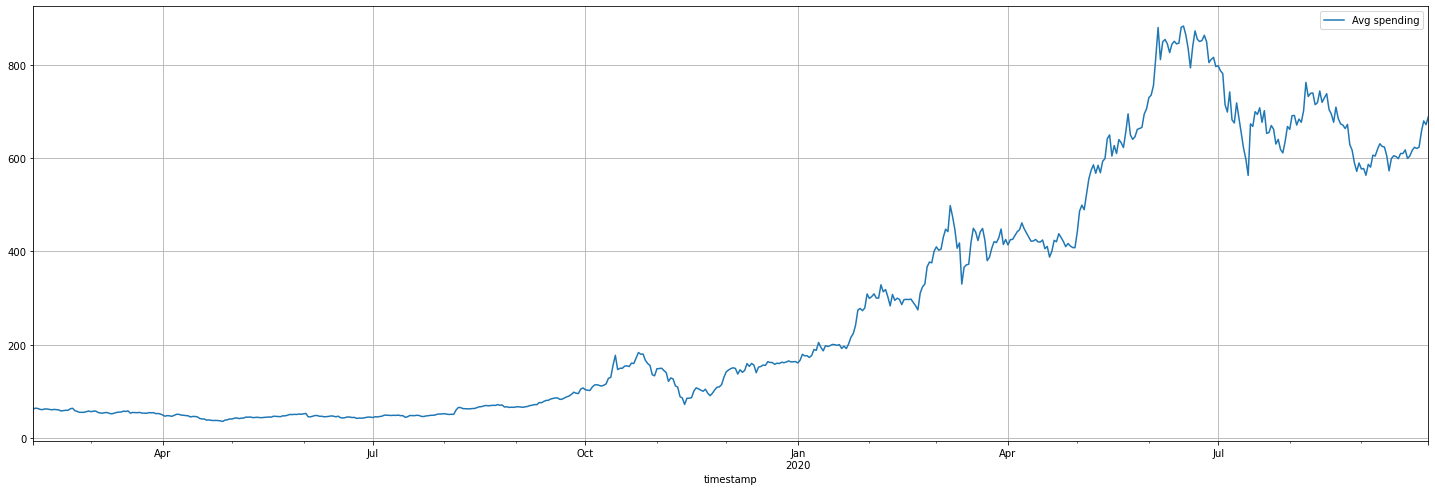

In [44]:
rcParams['figure.figsize'] = 25,8
df.plot(grid=True);

### 2.B Data Understanding (15 marks) 

#### a. Decompose the time series and check for components of time series. (4 MARKS)

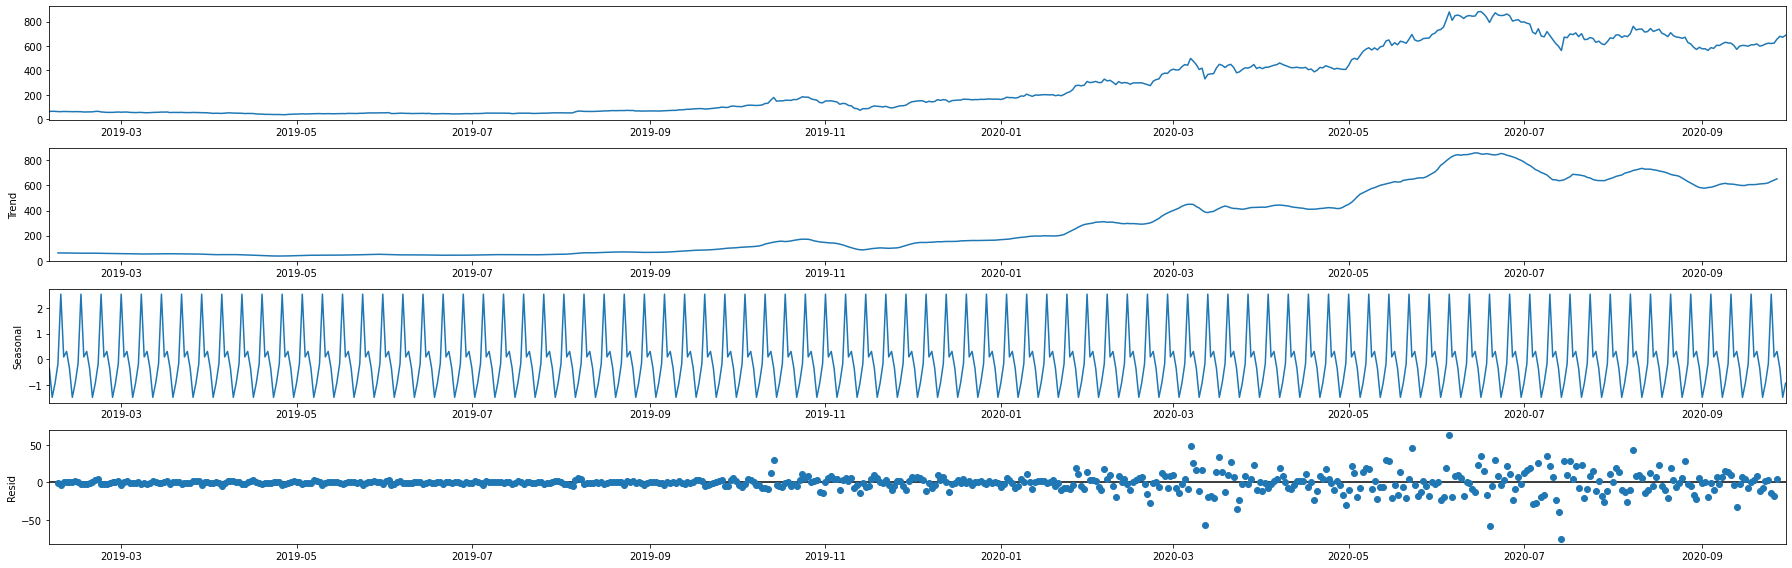

In [45]:
df_decomp=seasonal_decompose(df,model='additive')
df_decomp.plot();

#### b. Perform dicky fuller test to check the stationarity? What other actions will you take if series is non-stationary? (3+2 MARKS)

In [46]:
observations= df.values
test_result = adfuller(observations)

In [47]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -0.309083
p-value: 0.924208
Critical Values:
	1%: -3.44139
	5%: -2.86641
	10%: -2.56936


In [48]:
df_diff=df.diff().dropna()

In [49]:
observations= df_diff.values
test_result = adfuller(observations)

In [50]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -6.731903
p-value: 0.000000
Critical Values:
	1%: -3.44139
	5%: -2.86641
	10%: -2.56936


#### c. Plot AutoCorrelation and Partial AutoCorrelation function for original series? What is your inference from these plots?  (3+3 MARKS)

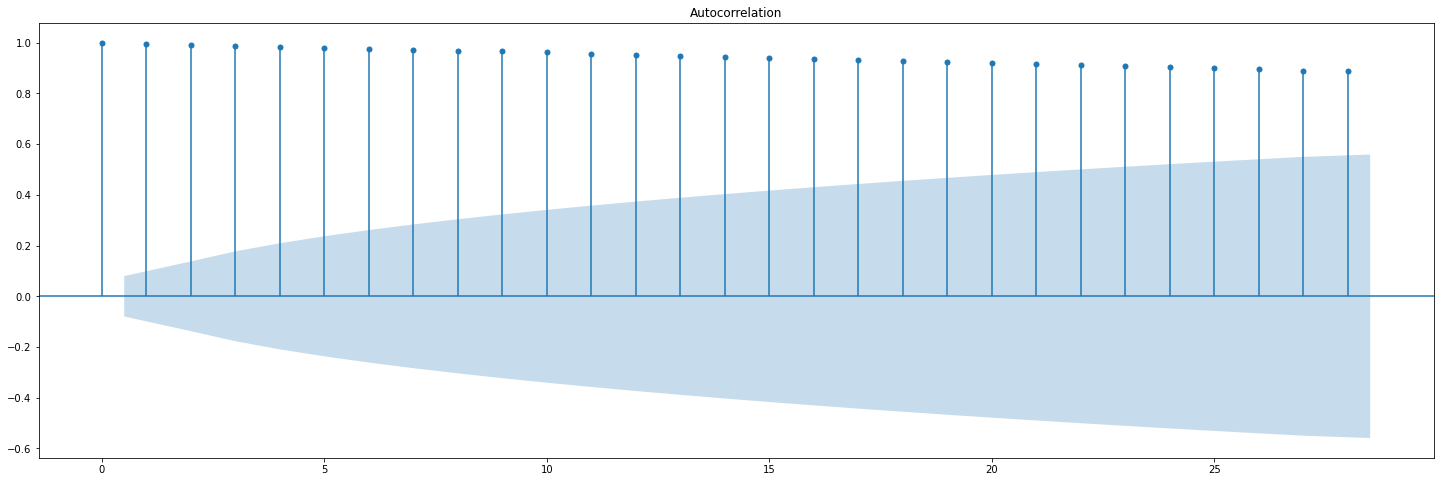

In [51]:
plot_acf(df);

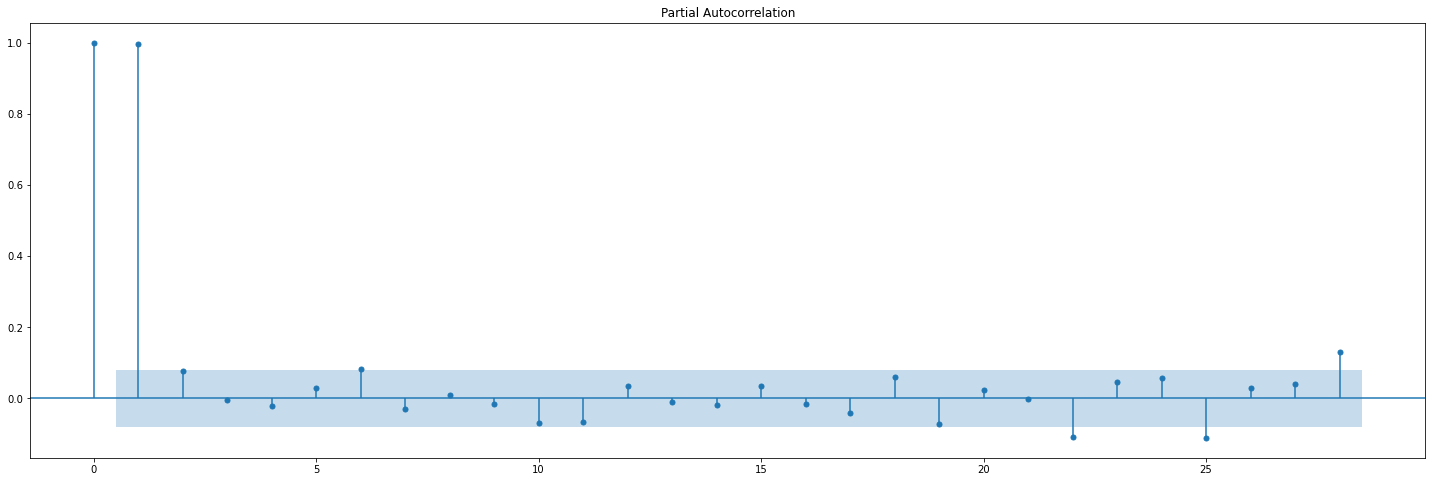

In [52]:
plot_pacf(df);

### 2.C Model Building (10 marks)

#### a. Split dataset into train and test sets. Use last two months of data for testing. (2 marks)

In [53]:
train_end=datetime(2020,7,30)
test_end=datetime(2020,9,30)

In [54]:
train             = df[:train_end] 
test              = df[train_end + timedelta(days=1):test_end]

In [55]:
train.shape

(543, 1)

In [56]:
test.shape

(62, 1)

#### b. Fit ARIMA model and observe the RMSE and MAPE values of the model for test data.(8 marks)

In [57]:
import itertools
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('parameter combinations for the Model')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

parameter combinations for the Model
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [58]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


In [59]:
for param in pdq:
            try:
                mod = ARIMA(train, order=param)
                results_Arima = mod.fit()
                print('ARIMA{} - AIC:{}'.format(param, results_Arima.aic))
                dfObj1 = dfObj1.append({'param':param, 'AIC': results_Arima.aic}, ignore_index=True)

            except:
                continue

ARIMA(0, 1, 0) - AIC:4507.985110657532
ARIMA(0, 1, 1) - AIC:4506.818387789178
ARIMA(0, 1, 2) - AIC:4508.728717443149
ARIMA(0, 1, 3) - AIC:4507.871170244165
ARIMA(1, 1, 0) - AIC:4506.956269164373
ARIMA(1, 1, 1) - AIC:4508.788015429749
ARIMA(1, 1, 2) - AIC:4510.484383170511
ARIMA(1, 1, 3) - AIC:4509.733670853919
ARIMA(2, 1, 0) - AIC:4508.462534781269
ARIMA(2, 1, 1) - AIC:4510.132237766878
ARIMA(2, 1, 3) - AIC:4484.243289488239
ARIMA(3, 1, 0) - AIC:4508.129721080497
ARIMA(3, 1, 1) - AIC:4509.606075275551
ARIMA(3, 1, 2) - AIC:4484.240533452492
ARIMA(3, 1, 3) - AIC:4485.269577565365


In [60]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
13,"(3, 1, 2)",4484.240533
10,"(2, 1, 3)",4484.243289
14,"(3, 1, 3)",4485.269578
1,"(0, 1, 1)",4506.818388
4,"(1, 1, 0)",4506.956269
3,"(0, 1, 3)",4507.871170
0,"(0, 1, 0)",4507.985111
11,"(3, 1, 0)",4508.129721
8,"(2, 1, 0)",4508.462535
2,"(0, 1, 2)",4508.728717


In [61]:
model = ARIMA(train,order=(3,1,2))

results_Arima = model.fit()

print(results_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Avg spending   No. Observations:                  542
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2235.120
Method:                       css-mle   S.D. of innovations             14.871
Date:                Sun, 28 Nov 2021   AIC                           4484.241
Time:                        18:10:01   BIC                           4514.307
Sample:                    02-05-2019   HQIC                          4495.998
                         - 07-30-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0536      0.620      1.698      0.089      -0.162       2.270
ar.L1.D.Avg spending     0.1525      0.044      3.493      0.000       0.067       0.238
ar.L2.D.Avg 

In [62]:
ARIMA_forecast=results_Arima.forecast(62)

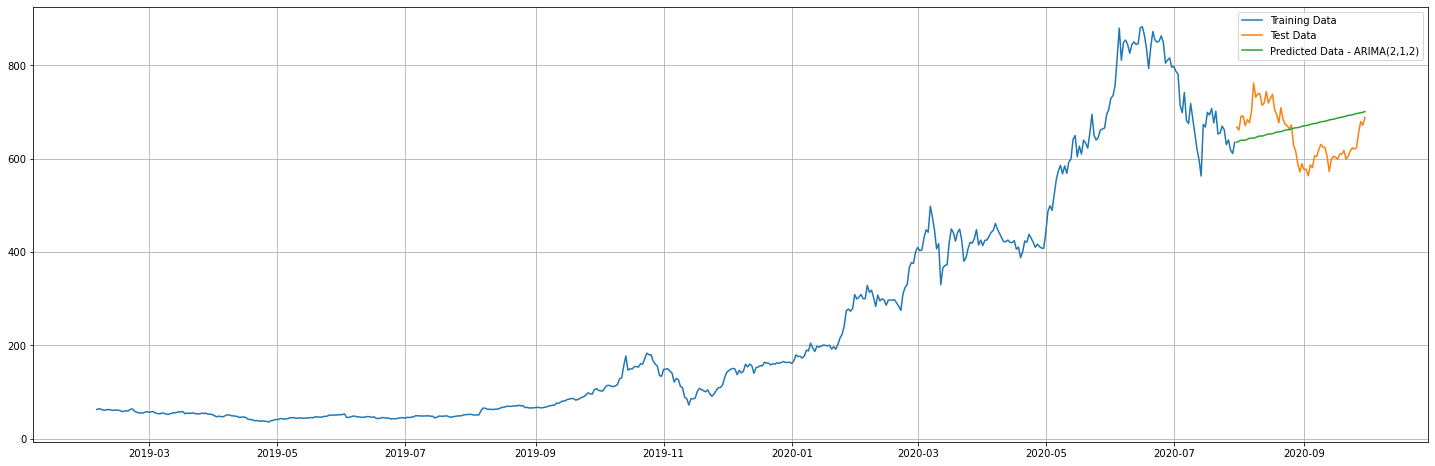

In [63]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,ARIMA_forecast[0],label='Predicted Data - ARIMA(2,1,2)')
plt.legend(loc='best')
plt.grid();

In [67]:
mean_squared_error(test['Avg spending'].values,ARIMA_forecast[0],squared=False)

68.71680095682868

In [68]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [69]:
MAPE(test['Avg spending'].values,ARIMA_forecast[0])

9.808660555389341

# Section C Total 30 Marks

### 3.A Fit exponential smoothing model and observe the residuals, RMSE and MAPE values of the model for test data. (10 MARKS)

In [70]:
model_DES = Holt(train,initialization_method='estimated')

In [71]:
model_DES = model_DES.fit(optimized=True)

In [72]:
model_DES.summary()

Dep. Variable:,Avg spending,No. Observations:,543
Model:,Holt,SSE,128215.885
Optimized:,True,AIC,2975.148
Trend:,Additive,BIC,2992.337
Seasonal:,None,AICC,2975.305
Seasonal Periods:,None,Date:,"Sun, 28 Nov 2021"
Box-Cox:,False,Time:,18:11:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9222078,alpha,True
smoothing_trend,0.000000,beta,True


In [73]:
DES_predict =  model_DES.forecast(len(test))

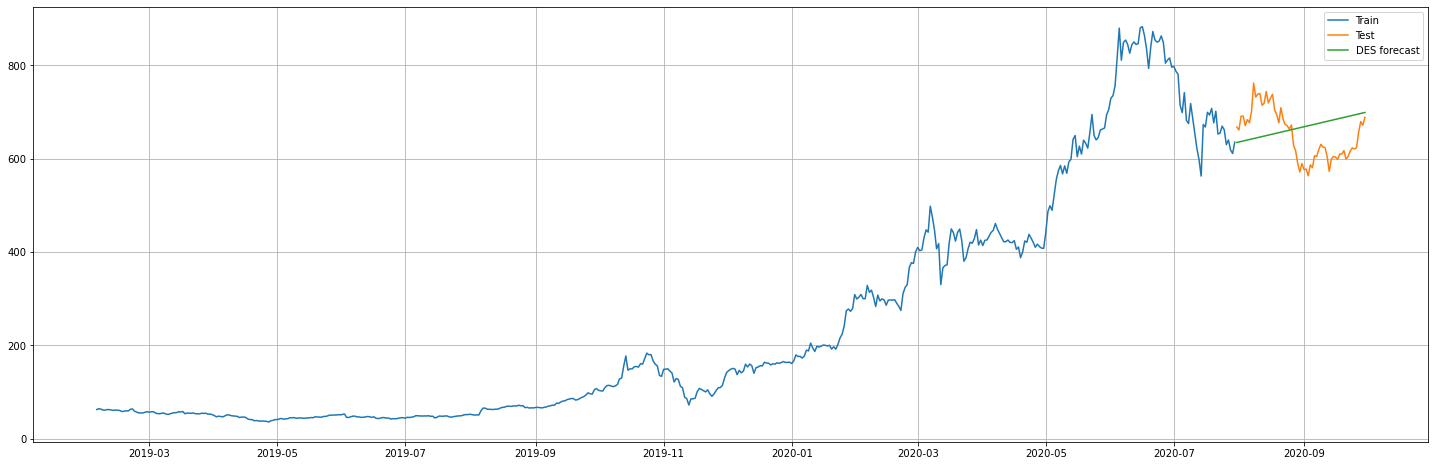

In [74]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(DES_predict, label='DES forecast')
plt.legend(loc='best')
plt.grid()

In [76]:
mean_squared_error(test['Avg spending'].values,DES_predict.values,squared=False)

68.28167207193324

In [77]:
MAPE(test['Avg spending'].values,DES_predict.values)

9.755673006286148


### 3.B How would you improve the exponential smoothing model? Make the changes and Fit the final exponential smoothing model. (10 MARKS)

In [137]:
model_DES = Holt(train,initialization_method='estimated')

In [138]:
model_DES = model_DES.fit(smoothing_level=0.9222078,smoothing_trend=0.0,optimized=False)

In [139]:
model_DES.summary()

Dep. Variable:,Avg spending,No. Observations:,543
Model:,Holt,SSE,129273.916
Optimized:,False,AIC,2979.611
Trend:,Additive,BIC,2996.799
Seasonal:,None,AICC,2979.767
Seasonal Periods:,None,Date:,"Sun, 28 Nov 2021"
Box-Cox:,False,Time:,18:15:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9222078,alpha,False
smoothing_trend,0.000000,beta,False


In [140]:
DES_predict =  model_DES.forecast(len(test))

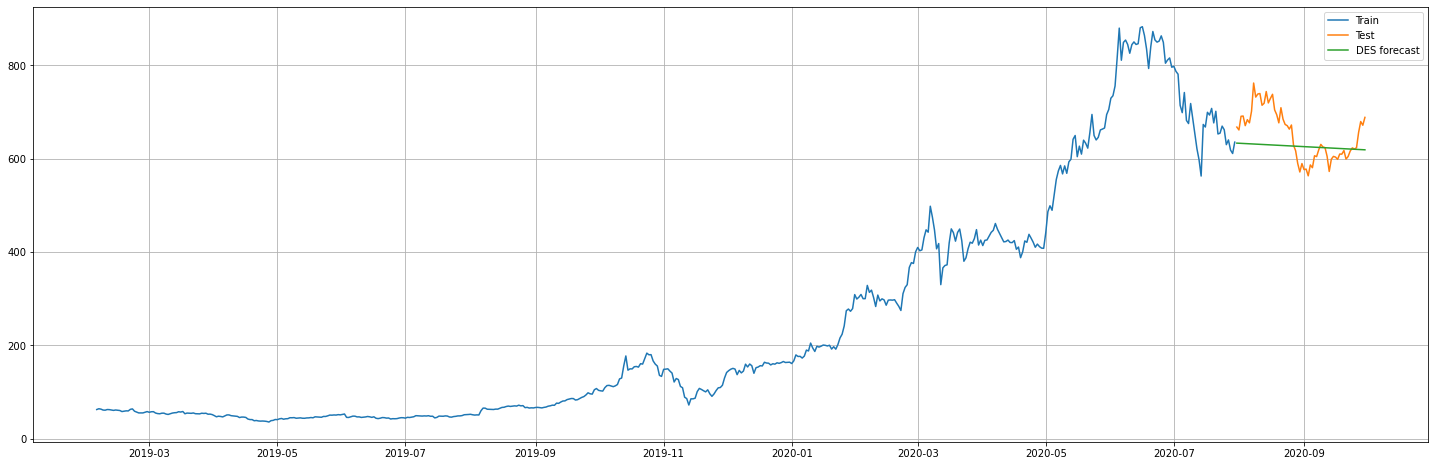

In [141]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(DES_predict, label='DES forecast')
plt.legend(loc='best')
plt.grid()

In [142]:
mean_squared_error(test['Avg spending'].values,DES_predict.values,squared=False)

55.97906728988743

In [143]:
MAPE(test['Avg spending'].values,DES_predict.values)

6.675270474778647

### 3.B Analyze the residuals of this final model. Feel free to use charts or graphs to explain. (5 MARKS)

In [144]:
residuals = test['Avg spending'] - DES_predict

In [145]:
residuals.values

array([ 34.40218354,  28.45672899,  57.99127445,  58.7958199 ,
        38.38036536,  51.44491081,  44.89945627,  70.09400172,
       130.66854717, 100.81309263, 107.66763808, 108.83218354,
        83.91672899,  88.51127445, 113.8758199 ,  89.68036536,
        99.62491081, 108.65945627,  75.43400172,  65.32854717,
        48.16309263,  80.83763808,  56.53218354,  45.46672899,
        43.04127445,  35.8758199 ,  44.94036536,   1.84491081,
        -9.76054373, -36.83599828, -54.80145283, -36.51690737,
       -49.19236192, -47.91781646, -62.09327101, -38.53872555,
       -44.2041801 , -18.40963464, -19.92508919,  -5.25054373,
         6.70400172,   1.30854717,   0.22309263, -18.32236192,
       -50.36781646, -23.92327101, -17.60872555, -18.9141801 ,
       -23.48963464, -11.91508919, -11.91054373,  -3.87599828,
       -21.97145283, -16.22690737,  -4.26236192,   2.68218354,
         0.43672899,   3.55127445,  36.6458199 ,  60.13036536,
        52.41491081,  69.49945627])

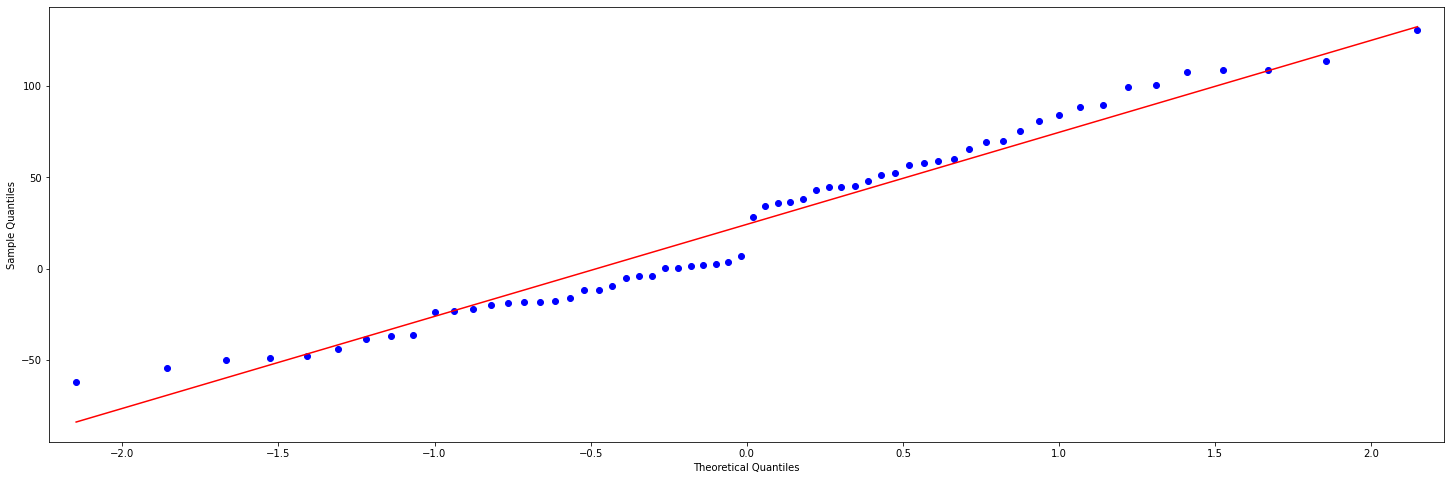

In [147]:
qqplot(residuals,line="s");

### 3.C Forecast the Avg spending for next 1 months using the final model? (5 MARKS)

In [148]:
model_DES = Holt(df,initialization_method='estimated')

In [149]:
model_DES = model_DES.fit(smoothing_level=0.9222078,smoothing_trend=0.00,optimized=False)

In [150]:
DES_forecast =  model_DES.forecast(30)

In [151]:
DES_forecast

2020-10-01    687.190825
2020-10-02    686.956279
2020-10-03    686.721734
2020-10-04    686.487189
2020-10-05    686.252643
2020-10-06    686.018098
2020-10-07    685.783552
2020-10-08    685.549007
2020-10-09    685.314461
2020-10-10    685.079916
2020-10-11    684.845370
2020-10-12    684.610825
2020-10-13    684.376279
2020-10-14    684.141734
2020-10-15    683.907189
2020-10-16    683.672643
2020-10-17    683.438098
2020-10-18    683.203552
2020-10-19    682.969007
2020-10-20    682.734461
2020-10-21    682.499916
2020-10-22    682.265370
2020-10-23    682.030825
2020-10-24    681.796279
2020-10-25    681.561734
2020-10-26    681.327189
2020-10-27    681.092643
2020-10-28    680.858098
2020-10-29    680.623552
2020-10-30    680.389007
Freq: D, dtype: float64

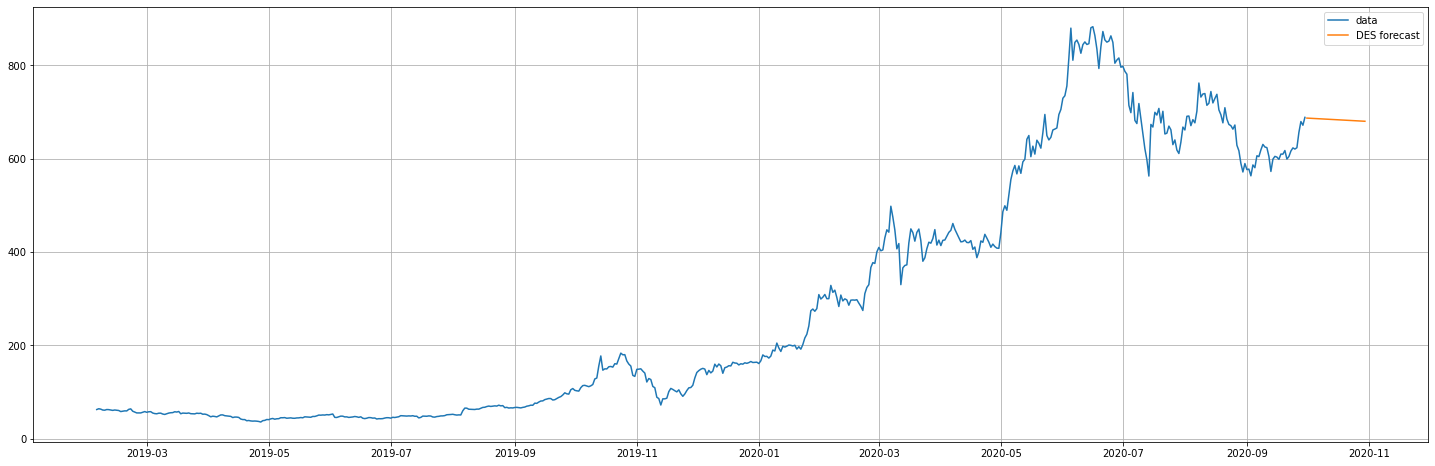

In [152]:
plt.plot(df, label='data')
plt.plot(DES_forecast, label='DES forecast')
plt.legend(loc='best')
plt.grid()

# END